# Plotting Aesthetics

For the following plots in this notebook, I am going to be using $\href{https://seaborn.pydata.org/}{Seaborn}$. This is a really cool statistical visualization library that makes it pretty easy to "beautify" your standard ```matplotlib``` plots. 

For example, here is a basic plot of some standard functions.

In [1]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

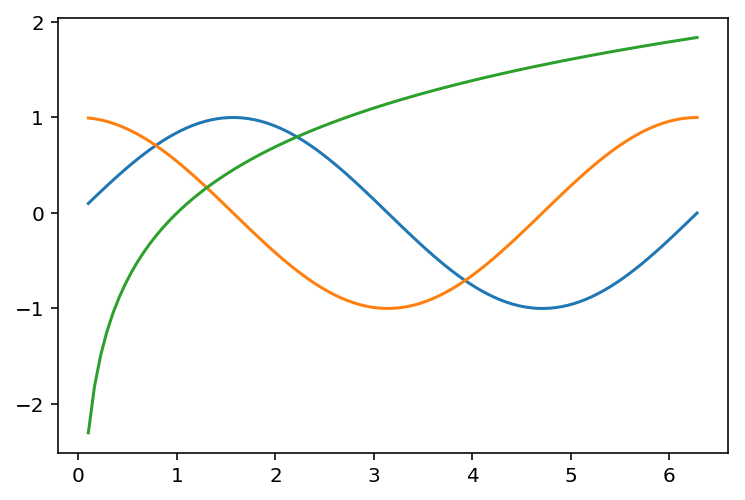

In [2]:
x = np.linspace(0.1, 2*np.pi, 100)
[plt.plot(x, func(x)) for func in (np.sin, np.cos, np.log)]
plt.show()

Now let's try doing the same thing again after importing ```Seaborn```

[[<matplotlib.lines.Line2D at 0x113644198>],

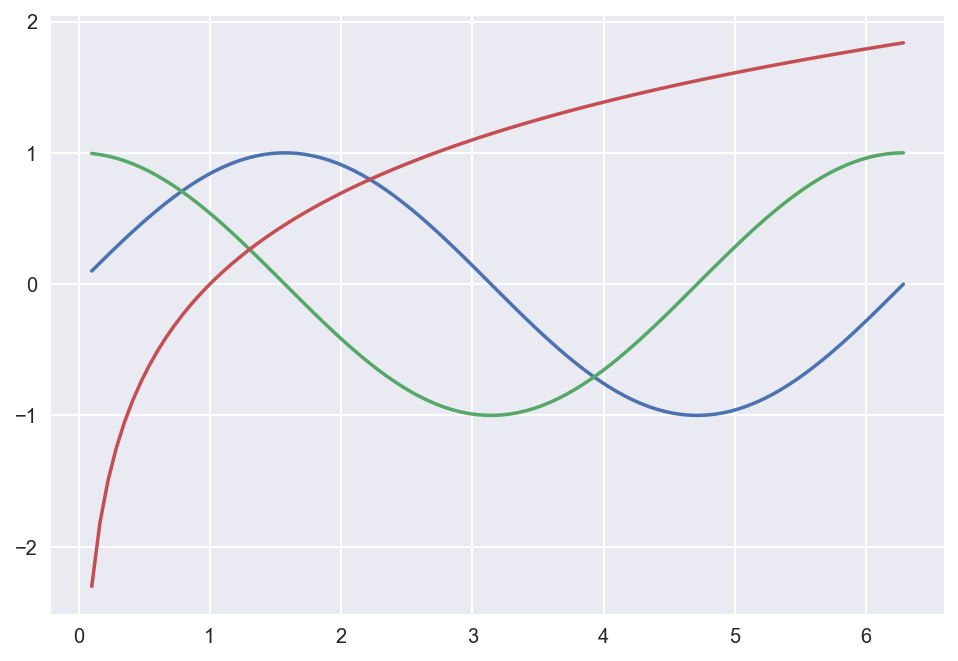

In [3]:
import seaborn as sns
fig = plt.figure()
[plt.plot(x, func(x)) for func in (np.sin, np.cos, np.log)]

This automatically adds a grid to the background, increases the figsize a bit, and adjusts the color palette. Let's try changing the theme and adjusting the color paleete.

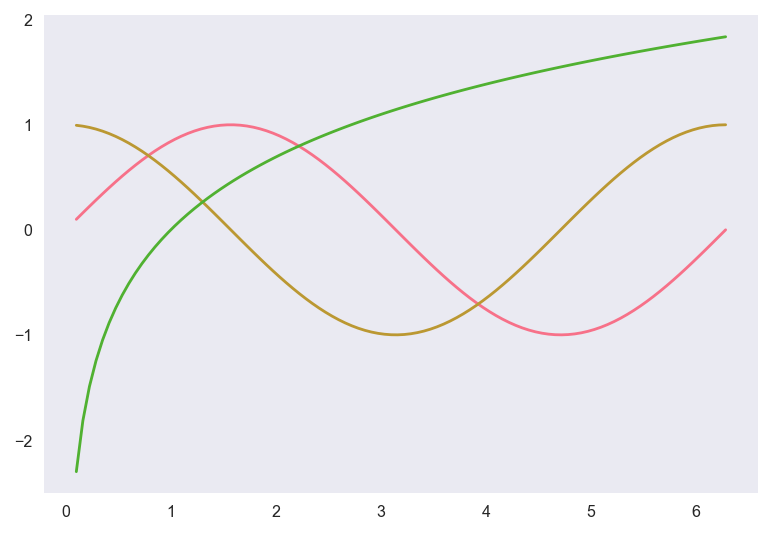

In [10]:
sns.set_context('paper') # paper, talk, poster
sns.set_palette('husl')
sns.set_style('dark')

[plt.plot(x, func(x)) for func in (np.sin, np.cos, np.log)]
plt.show()

Different color palettes can be previewed using ```palplot``` within ```Seaborn```.

```palplot``` can take in an RGB triple like (0,0,1) and displays the corresponding color. In this case, blue.

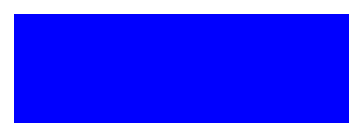

In [11]:
sns.palplot((0,0,1))

```Seaborn``` has a large catalog of different palettes that return triples just like this. Many of the palettes are tailored based on the type of data being visualized, such as sequentially varying data vs. qualitatively varying data, or based on the type of color blindness an audience member may have. A nice overview of the different palettes available can be viewed here. http://seaborn.pydata.org/tutorial/color_palettes.html

I happen to be a fan of xkcd and like using the color code names that were generated in the public survey here https://blog.xkcd.com/2010/05/03/color-survey-results/

It just so happens that ```Seaborn``` has a function ```xkcd_palette``` that converts the user generated names into an RGB triple for use in ```matplotlib```. For example, "barbie pink" would have the following RGB triple:

In [12]:
sns.xkcd_palette(["barbie pink"])

[(0.996078431372549, 0.27450980392156865, 0.6470588235294118)]

This returns a list, but since we are just giving it one color, let's just take the first (and only) element and display it in ```palplot```

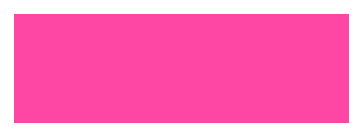

In [13]:
sns.palplot(sns.xkcd_palette(["barbie pink"])[0])

We can now take the contents of ```palplot``` and use this like we would any other color in ```matplotlib```

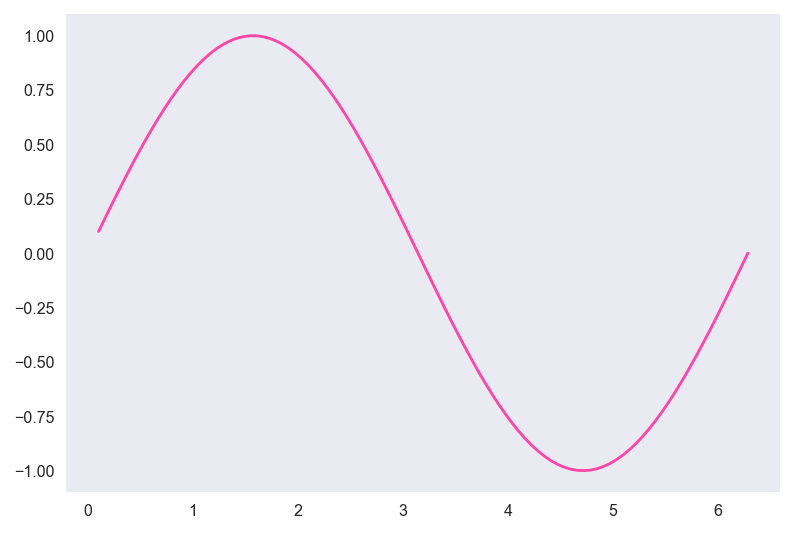

In [14]:
plt.plot(x, np.sin(x), c=sns.xkcd_palette(["barbie pink"])[0])

This would get a bit cumbersome to type every time we wanted to use a cuustom xkcd color, so let's make a convenience function.

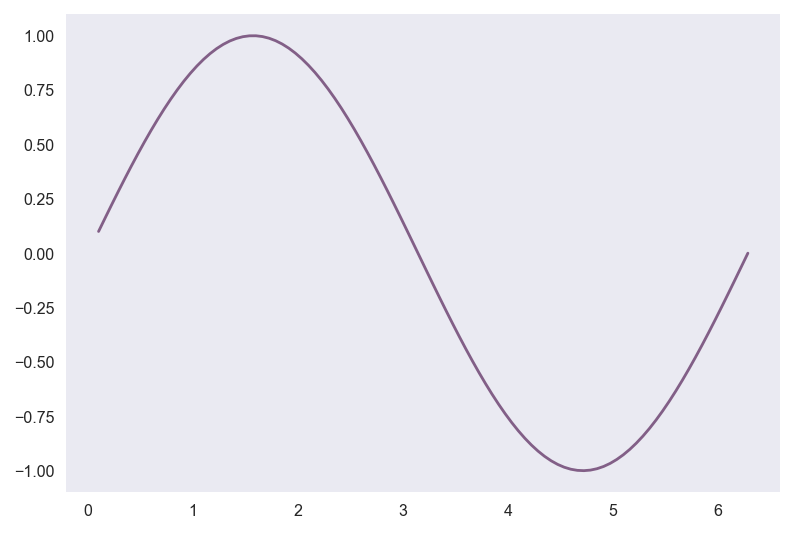

In [16]:
def xkcd(color): return sns.xkcd_palette([color])[0] # convenience function

plt.plot(x, np.sin(x), c=xkcd("dusty purple"))

This notebook was written using a dark theme for the Jupyter notebook, so I am also going to be using a custom dark theme for ```Seaborn``` for the rest of this notebook. This part can be skipped, or even modified, to make a plotting theme that looks best to you.

In [18]:
# some plotting preferences for a dark themed notebook
sns.set_style('darkgrid')
dark_style = {'axes.labelcolor': 'white',
              'xtick.color': 'white',
              'ytick.color': 'white',
              'grid.color': 'lightgrey'
            }

sns.set_style(dark_style)

# The Simulation

##### This notebook sets up and runs a simple orbital simulation in 2D using a Runge-Kutta 4th Order integration scheme with adaptive timestepping. The simulation assumes an inertial Cartesian coordinate system with a solar mass object at the origin and massless test particle placed on the negative-x axis (horizontal axis). Here is some brief info of what you can do:

* The initial conditions defined in ```orb_plot ``` can be adjusted in real time under  **Simulation Viewer ** by using the sliders. 
* The position and velocity are tabulated and saved (in cgs) to ```orb.dat``` in the same directory as this notebook and can be viewed in **Taking a look at the data**. A few diagnostic plots are generated from the data as well.
* A movie of the evolution of the orbit can also be made under **Movie Maker**.

In [20]:
from astropy import units as u
from astropy import constants as c
from astropy.io import ascii

In [21]:
# system constants
G    = (1 * c.G).cgs.value
M    = (1 * u.solMass).cgs.value
au   = (1 * u.AU).cgs.value
year = (1 * u.yr).cgs.value

In [22]:
def sho_func(t, uin): # calculates derivatives for RK4
    # position and velocity
    r = uin[:2]
    v = uin[2:]
    
    # distance of point mass from each M
    d = np.linalg.norm(0 - r)

    # calulating accelerations
    g = (G*M/d**3) * (0 - r)
    
    derivs = np.ndarray(4)
    derivs[:2] = v
    derivs[2:] = g
    
    return derivs

In [23]:
def sho_RK4(t, u_old, dt):
    K1 = sho_func(t, u_old)
    K2 = sho_func(t + dt/2, u_old + K1*dt/2)
    K3 = sho_func(t + dt/2, u_old + K2*dt/2)
    K4 = sho_func(t + dt, u_old + K3*dt)
    
    u_new = u_old + (dt/6)*(K1 + 2*(K2 + K3) + K4)
    return u_new

## Plotting the Orbit

In [24]:
def orb_plot(x_pos, x_vel, y_vel, T, f): # arguments read in from slider in next section
    # Initial conditions
    x = -x_pos*au
    y = 0 # because of circular symmetry, it doesn't really matter what we put for y
    a0 = np.sqrt(x**2 + y**2)
    v_circ = np.sqrt(G * M / a0)

    vx = x_vel*v_circ
    vy = -y_vel*v_circ
    #T0 = 2*np.pi*np.sqrt(a0**3/(G*M))
    T0  = year

    tmax  =  T*T0
    
    pos_0 = np.array([x, y])
    vel_0 = np.array([vx, vy])

    uold = np.zeros(4)
    uold[:2] = pos_0
    uold[2:] = vel_0

    x = []
    y = []
    vx = []
    vy = []
    
    x.append(uold[0])
    y.append(uold[1])
    vx.append(uold[2])
    vy.append(uold[3])
    
    fig, ax = plt.subplots(figsize=(6,6))
    fig.patch.set_alpha(0)

    # Integrate orbit
    t = 0
    v0 = np.sqrt(uold[2]**2 + uold[3]**2) # turn on inside for adaptive
    dt = 10**(f) * np.abs(x[0]) / v0
    #for t in np.arange(0, tmax+dt, dt):
    while (t <= tmax):
        # v0 based on speed at beginning of current timestep
        #v0 = np.sqrt(uold[2]**2 + uold[3]**2) 
        #dt = 10**(f) * np.abs(x[0]) / v0
        unew = sho_RK4(t, uold, dt) # integrate the orbit

        # hold positions and velocities
        x.append(unew[0])
        y.append(unew[1])
        vx.append(unew[2])
        vy.append(unew[3])

        uold = unew # step forward
        
        t += dt

    # write to file
    ascii.write([x,y,vx,vy], './orb.dat', names=['x', 'y', 'vx', 'vy'],
               overwrite=True)
    
    x = np.array(x) / au
    y = np.array(y) / au
    vx = np.array(vx) / v_circ
    vy = np.array(vy) / v_circ

    ax.set_aspect(aspect='equal')
    lim = 2.5
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    # plot trajectory
    ax.plot(x, y, color=xkcd("amber"))
    
    # overplot circular orbit
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), ls='--', color=xkcd("bright turquoise"))
    
    # plot starting and ending points
    ax.plot(x[0], y[0], color=xkcd("light lavender"), ms=10, marker='X')
    ax.plot(x[-1], y[-1], color=xkcd("fluorescent green"), ms=10, marker='o')
    
    # show the star!
    host = plt.Circle((0, 0), 0.3, fc=xkcd("pinkish orange"))
    ax.add_artist(host)
    
    # graphically show initial velocity vector
    ax.arrow(x[0], y[0], vx[0], vy[0], color='w', head_width=0.05, lw=2)

    fig.tight_layout()
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    plt.show() # to update live plot

## Simulation Viewer

The widgets below allow us to dynamically feed different initial conditions to the integrator to see in realtime how it effects the trajectory of Earth. Each of the sliders are created as a ```ipywidgets.FloatSlider``` within  ```ipywidgets```. The sliders are then displayed as an interactive slider within the notebook by sending them to ```ipywidgets.interactive```. The value displayed below each slider widget is sent to ```orb_plot```, the first argument of ```interactive```, and read in as a function argument of ```orb_plot```. The plot of Earth's trajectory is then updated and displayed below based on the user's choices.

In [34]:
import ipywidgets as widgets

box_layout = widgets.Layout(
    display='inline-flex',
    flex_flow='row wrap',
    justify_content='flex-start'
)

items = [
    widgets.FloatSlider(value=1, min=0.5, max=1.5, step=0.01, 
                        description='$-r_x / AU$'),
    widgets.FloatSlider(value=0, min=-2, max=2, step=0.01, 
                        description='$v_x / v_c$'),
    widgets.FloatSlider(value=1, min=-2, max=2, step=0.01, 
                        description='$-v_y / v_c$'),
    widgets.FloatSlider(value=1, min=0.1, max=5, step=0.01, 
                        description='$T$ / $year$'),
    widgets.FloatSlider(value=-1, min=-2, max=2, step=0.01, 
                        description=r'$f,\ \text{where }dt = 10^f \cdot x_0 / v$')
        ]

w = widgets.interactive(orb_plot, x_pos=items[0], x_vel=items[1], 
                        y_vel=items[2], T = items[3], f = items[4])

w.layout = box_layout # put the sliders in a box arrangment as opposed to column

# show the widgets
w

Quick summary of the sliders
* $-r_x / 1\ AU$: how far along the x-axis, in AU, the test particle starts. This sets $x_0$.
* $v_x/v_c$: initial x component of the test particle velocity in units of the circular speed $v_c = \sqrt{GM/x_0}$
* $-v_y/v_c$: initial y component of the test particle velocity in units of $v_c$, with down defined as negative.
* $T/1\ year$: How long the simulation runs for, in units of 1 year.
* $f\ \left(dt = 10^f \cdot x_0 / v\right)$: defines the characterisic lengthscale used for cell crossing time in adaptive timestep procedure. $f$ scales the power of ten multiplied by the intitial distance of the test particle from the central mass. $v$ is the total speed of the test particle at the beginning of the current timestep. You can think of larger values of $f$ as making the simulation more "inaccurate" because of the courser timesteps that are made.


Quick summary of the graphical elements
* cyan: the reference circular orbit of the Earth
* orange: current trajectory of the Earth
* white arrow: initial velocity vector
* purple X: starting location
* green circle: final location of the Earth
* dark orange circle: the Sun

# Taking a Look at the Data

From the position and velocity information stored in ```orb.dat``` we can derive different physical quantities like the specific energy and angular momentum of our test particle. Plotting how these quantites vary over time is a nice way to check if our integrator is doing a good job of conserving these quantites. 

Since the test particle is "massless" $(m\to 0)$, the specific energy $E$ and specific angular momentum $L$ is used because it already divides through regular energy and angular momentum by $m$:
$$\begin{aligned} 
    E &= \frac{1}{2}v^2 - \frac{GM}{r} \\ 
    L &= r \times v \quad.
\end{aligned}$$

Typically, adaptive time stepping is a handy way to improve how well the RK4 integrator conserves these quantities. The naive prescription I used just scales the timesteps by how fast the test particle is crossing a given length scale $(\Delta t = 10^f r_0 / v)$. Feel free to play around with the "fudge factor" $f$ on the interactive slider or create your own adaptive time stepping prescription!

In [32]:
t = ascii.read('./orb.dat')
t

x,y,vx,vy
float64,float64,float64,float64
-1.70541572598e+13,0.0,1422691.90827,-1757442.94551
-1.50582248852e+13,-2.03835911533e+12,2016681.98452,-1717398.00347
-1.22767424957e+13,-3.96197799627e+12,2782697.83027,-1543293.78161
-8.44362874717e+12,-5.52127851069e+12,3846179.70829,-1034540.15827
-3.10976323676e+12,-5.97505829393e+12,5344891.81321,634382.635337
3.30528958472e+12,-2.34787607726e+12,4026300.96202,6084500.333
4.4320349928e+12,4.65209790284e+12,-1254740.77219,4646127.36878
2.02468153784e+12,8.62189133533e+12,-2513747.17029,2308520.2211
-1.03198742331e+12,1.03018264001e+13,-2622442.52276,653032.050028


### Calculate and Plot Energy and Angular Momentum

When making plots are quantities that can potentially get ridiculously large or small over time, it can be helpful to normalize them against an initial quantity. For example, plotting the change it total energy of the Earth normalized by its initial energy is a lot more informative than just plotting the raw value of the total energy without any sort of referene. Similary, plotting the change in angular momentum normalized to the initial angular momentum is more informative about the conservation of this quantity. 

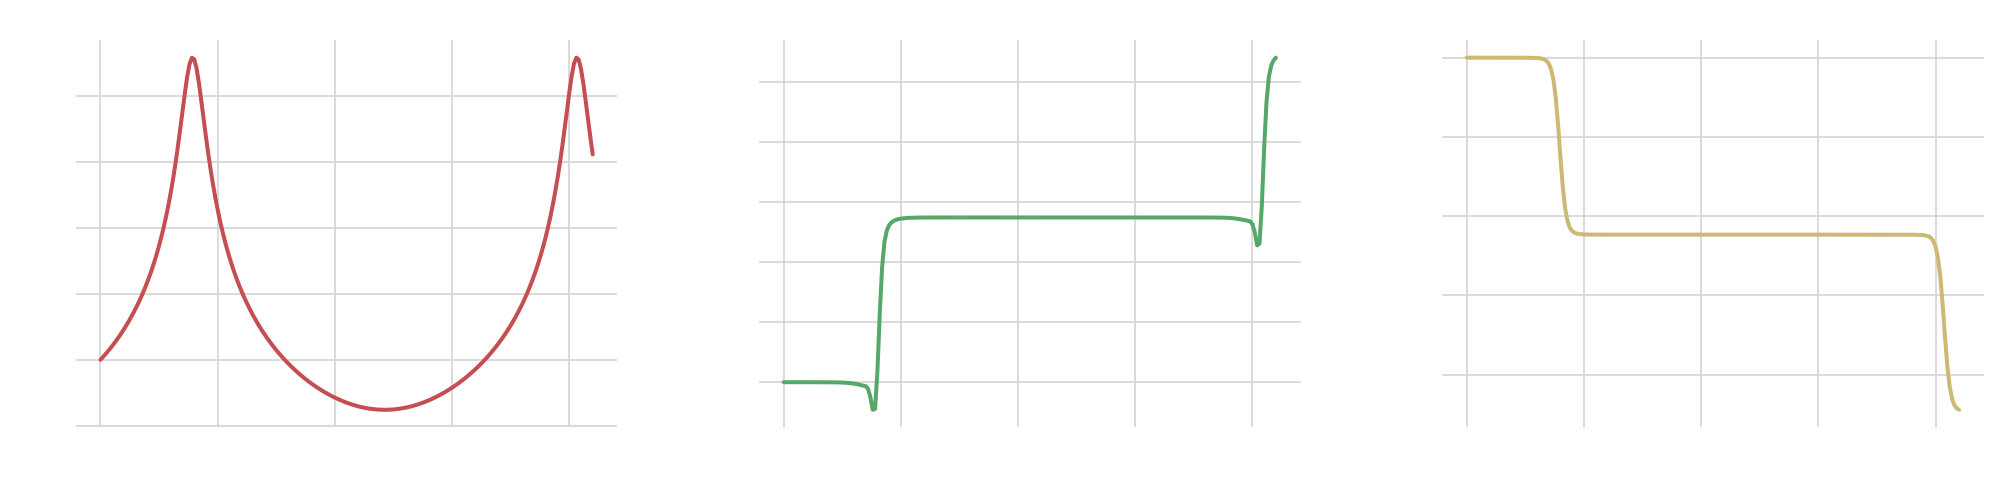

In [29]:
###############################################################
# Calculate
###############################################################
dist = np.sqrt(t['x']**2 + t['y']**2) # distance

speed = np.sqrt(t['vx']**2 + t['vy']**2) # speed
speed_0 = np.sqrt(t['vx'][0]**2 + t['vy'][0]**2)

spec_E = 0.5*speed**2 - G*M/dist # specific energy
spec_E0 = 0.5*speed[0]**2 - G*M/dist[0]

spec_L = []
for i in range(len(t['x'])):
    r = np.array([t['x'][i], t['y'][i], 0])
    v = np.array([t['vx'][i], t['vy'][i], 0])
    spec_L_i = np.linalg.norm(np.cross(r, v))
    spec_L.append(spec_L_i)
r0 = np.array([t['x'][0], t['y'][0], 0])
v0 = np.array([t['vx'][0], t['vy'][0], 0])
spec_L0 = np.linalg.norm(np.cross(r0, v0))

###############################################################
# Plot
###############################################################
sns.set_context('paper')
sns.set_color_codes('deep')
fig, ax = plt.subplots(1, 3, figsize=(14,3.5))
fig.patch.set_alpha(0)

# speed
ax[0].plot(speed / speed_0, 'r', lw=2)
ax[0].set_xlabel('step')
ax[0].set_ylabel('$v/v_0$')
ax[0].set_title('speed', color='w')

# specific energy
ax[1].plot((spec_E - spec_E0) / spec_E0, 'g', lw=2)
ax[1].set_xlabel('step')
ax[1].set_ylabel('$\Delta E/E_0$')
ax[1].set_title('energy', color='w')

# specific angular momentum
ax[2].plot((spec_L - spec_L0) / spec_L0, 'y', lw=2)
ax[2].set_xlabel('step')
ax[2].set_ylabel('$\Delta L/L_0$')
ax[2].set_title('angular momentum', color='w')

fig.tight_layout()
fig.patch.set_alpha(0)

for a in ax: 
    a.patch.set_alpha(0)
    a.yaxis.get_major_formatter().set_powerlimits((10, 10))

# Movie Maker

We can also use the data in ``` orb.dat ``` to create an animation of the interactive plot from earlier.

In [30]:
from matplotlib import animation, rc
from IPython.display import HTML

### Low Quality Preview

In [33]:
# set up the initial plot
fig, ax = plt.subplots(figsize=(4,4))
plt.close()
lim = 2.5
ax.set_xlim(( -lim, lim))
ax.set_ylim((-lim, lim))

host = plt.Circle((0, 0), 0.3, fc=xkcd("pinkish orange"))
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
line = [host, line1, line2, line3]

# initialization function: plot the background of each frame
def init():
    ax.add_patch(host)
    line[1].set_data([], [])
    line[2].set_data([], [])
    line[3].set_data([], [])
    return line

# animation function. This is called sequentially
def animate(i):
   # plot the trajectory
    line[1].set_data(t['x'][:i+1] / au, t['y'][:i+1] / au) 
    # the +1 makes it inclusive
    line[1].set_color('orange')
    
    # add a point at the beginning
    line[2].set_data(t['x'][0] / au, t['y'][0] / au)
    line[2].set_marker('X')
    line[2].set_markersize(10)
    line[2].set_color(xkcd("light lavender"))
    
    # add a point at the end
    line[3].set_data(t['x'][i] / au, t['y'][i] / au)
    line[3].set_marker('o')
    line[3].set_markersize(10)
    line[3].set_color(xkcd("fluorescent green"))

    return line

# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
                    wspace=None, hspace=None)
N = len(t['x'])
spf = 0.05 # seconds per frame
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, 
                               interval=spf * 1000, blit=True)
HTML(anim.to_html5_video())

Let's dissect ```FuncAnimation``` a bit. 
* `fig`: figure object that the movie will be made on top off
* `animate`: function that updates the plot. can be controlled by iterator `i` as first argument of `animate`
* `init_func`: can be thought of as the first frame that is drawn in the movie. If omitted, the first frame drawn is just the first frame created by `animate`
* `frames`: number of still images that will be sown together by ffmpeg and interval is the delay in milliseconds before showing the next frame of the movie. Feel free to play around with both to achieve a desired frame rate
* `interval`: time in milliseconds between displaying the next frame
* `blit`: speeds up processing of the movie by only re-drawing the parts of the frame that have changed

### High Quality Movie

A higher quality mp4 can also be saved using ```FFMpegWriter```. The codec can be adjusted for compatibility on different computers.

In [ ]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)
spf = 0.05 # seconds per frame

FFMpegWriter = animation.writers['ffmpeg']

# Change the video bitrate as you like 
mywriter = FFMpegWriter(fps=15)

anim = animation.FuncAnimation(fig, animate, frames=N, init_func=init, 
                               interval = (spf * 1000), blit=True)

anim.save("./orb.mp4", writer=mywriter, dpi=500, codec=None)